Loading dataset...
  4743 training examples
  Actual number of tfidf features: 10000
Some random words in the vocabulary:
  nursery
  hwhh
  cities
  fair
  ranged
  dot
  spokesman
  lapse
  esy
  443

Performing dimensionality reduction using LSA


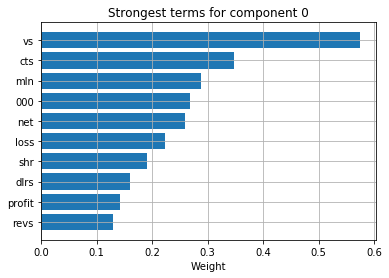

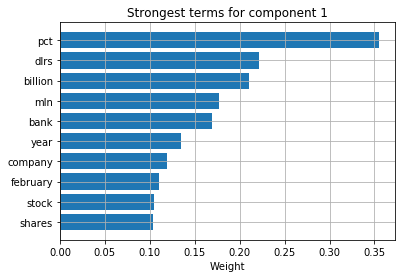

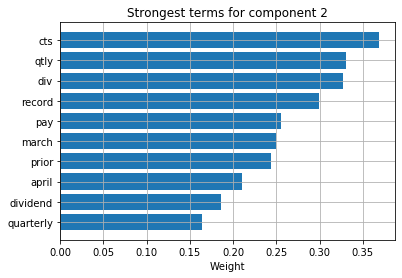

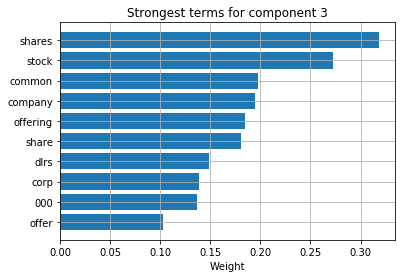

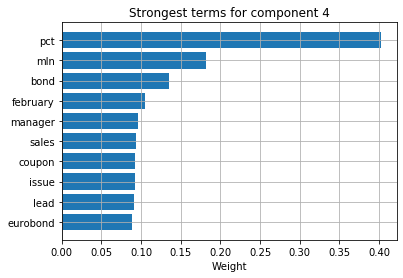

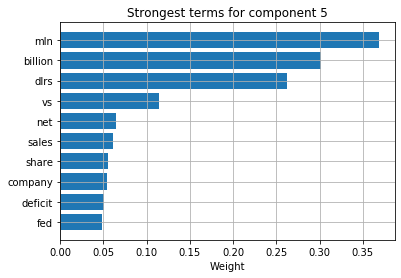

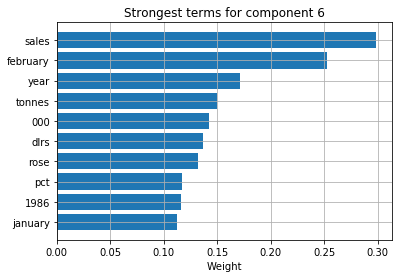

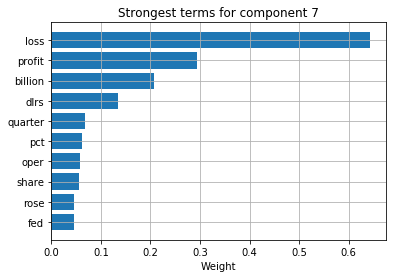

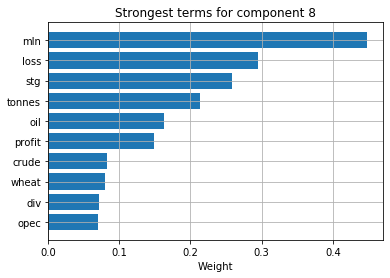

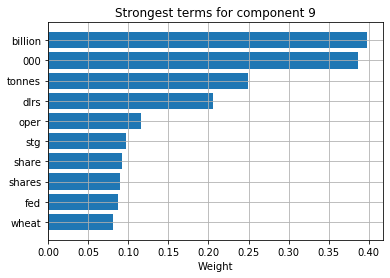

In [2]:
#!/usr/bin/env python
"""
Perform some analysis on the top components of SVD.

This script takes articles from the Reuters classification dataset, then
applies LSA to them to create compact feature vectors.

We look at some properties of these vectors and the SVD matrix in order to gain
some insight into how they work.

@author: Chris McCormick
"""

import pickle
import time
import numpy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from pylab import *

import random

###############################################################################
#  Load the raw text dataset.
###############################################################################

print("Loading dataset...")

# The raw text dataset is stored as tuple in the form:
# (X_train_raw, y_train_raw, X_test_raw, y_test)
# The 'filtered' dataset excludes any articles that we failed to retrieve
# fingerprints for.
raw_text_dataset = pickle.load( open( "data/raw_text_dataset.pickle", "rb" ) )
X_train_raw = raw_text_dataset[0]

print("  %d training examples" % (len(X_train_raw)))

###############################################################################
#  Use LSA to vectorize the articles.
###############################################################################

# Tfidf vectorizer:
#   - Strips out “stop words”
#   - Filters out terms that occur in more than half of the docs (max_df=0.5)
#   - Filters out terms that occur in only one document (min_df=2).
#   - Selects the 10,000 most frequently occuring words in the corpus.
#   - Normalizes the vector (L2 norm of 1.0) to normalize the effect of 
#     document length on the tf-idf values. 
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)

# Build the tfidf vectorizer from the training data ("fit"), and apply it 
# ("transform").
X_train_tfidf = vectorizer.fit_transform(X_train_raw)

print("  Actual number of tfidf features: %d" % X_train_tfidf.get_shape()[1])

# Get the words that correspond to each of the features.
feat_names = vectorizer.get_feature_names()

# Print ten random terms from the vocabulary
print("Some random words in the vocabulary:")
for i in range(0, 10):
    featNum = random.randint(0, len(feat_names))
    print("  %s" % feat_names[featNum])
    
print("\nPerforming dimensionality reduction using LSA")
t0 = time.time()

# Project the tfidf vectors onto the first N principal components.
# Though this is significantly fewer features than the original tfidf vector,
# they are stronger features, and the accuracy is higher.
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

# The SVD matrix will have one row per component, and one column per feature
# of the original data.

#for compNum in range(0, 100, 10):
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = numpy.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = arange(10) + .5    # the bar centers on the y axis
    
    figure(compNum)
    barh(positions, weights, align='center')
    yticks(positions, terms)
    xlabel('Weight')
    title('Strongest terms for component %d' % (compNum))
    grid(True)
    show()



